## Import Statements

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from os.path import join
from src.data_loading import load_physionet_dataset, prepare_training_data




## Data Loading

We load the Phyionet dataset using the given helper function. Then we investigate the information in the dataset and check how many recordings are associated with the patients. 



<class 'pandas.core.frame.DataFrame'>
Index: 21396 entries, 1 to 21837
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21396 non-null  float64
 1   age                           21396 non-null  float64
 2   sex                           21396 non-null  int64  
 3   height                        6919 non-null   float64
 4   weight                        9367 non-null   float64
 5   nurse                         19949 non-null  float64
 6   site                          21379 non-null  float64
 7   device                        21396 non-null  object 
 8   recording_date                21396 non-null  object 
 9   report                        21396 non-null  object 
 10  scp_codes                     21396 non-null  object 
 11  heart_axis                    13228 non-null  object 
 12  infarction_stadium1           5603 non-null   object 
 13  infarc

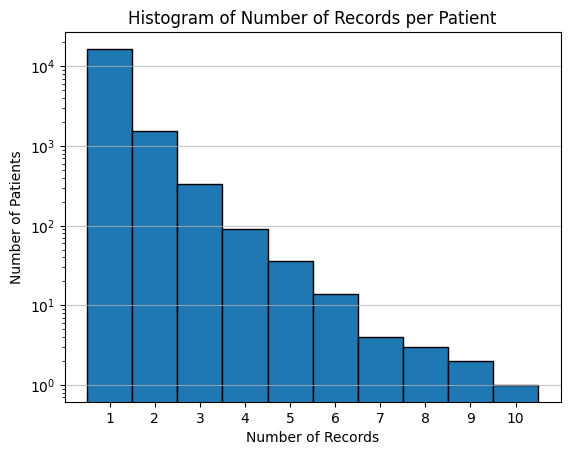

In [3]:
path_to_data = "../data/physionet.org/files/ptb-xl/1.0.2/"

df = load_physionet_dataset(path=path_to_data, sampling_rate=100)
print(df.info())
# print(df.head())

patient_record_counts = df['patient_id'].value_counts()

plt.yscale('log')
plt.hist(patient_record_counts, bins=range(1, patient_record_counts.max() + 2), edgecolor='black', align='left')
plt.title('Histogram of Number of Records per Patient')
plt.xlabel('Number of Records')
plt.ylabel('Number of Patients')
plt.xticks(range(1, patient_record_counts.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

## Patient Analysis

We now try to understand the dataset distribution by analyzing patient statistics

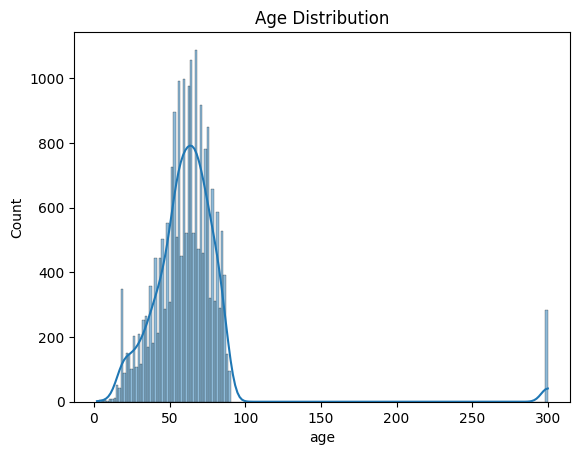

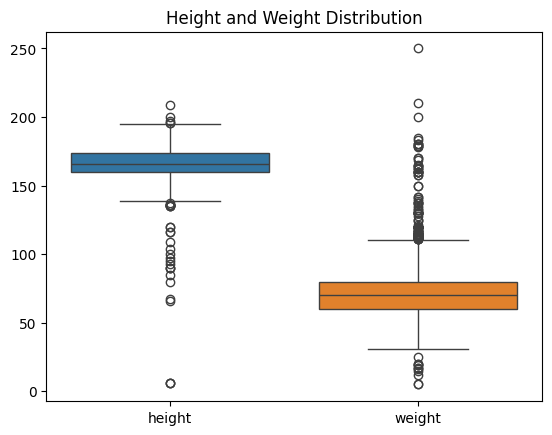

In [13]:
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.boxplot(data=df[['height', 'weight']])
plt.title('Height and Weight Distribution')
plt.show()

## Data Origin

We now try to analyze the diversity of the dataset by investigating the origin, such as devices, and sites

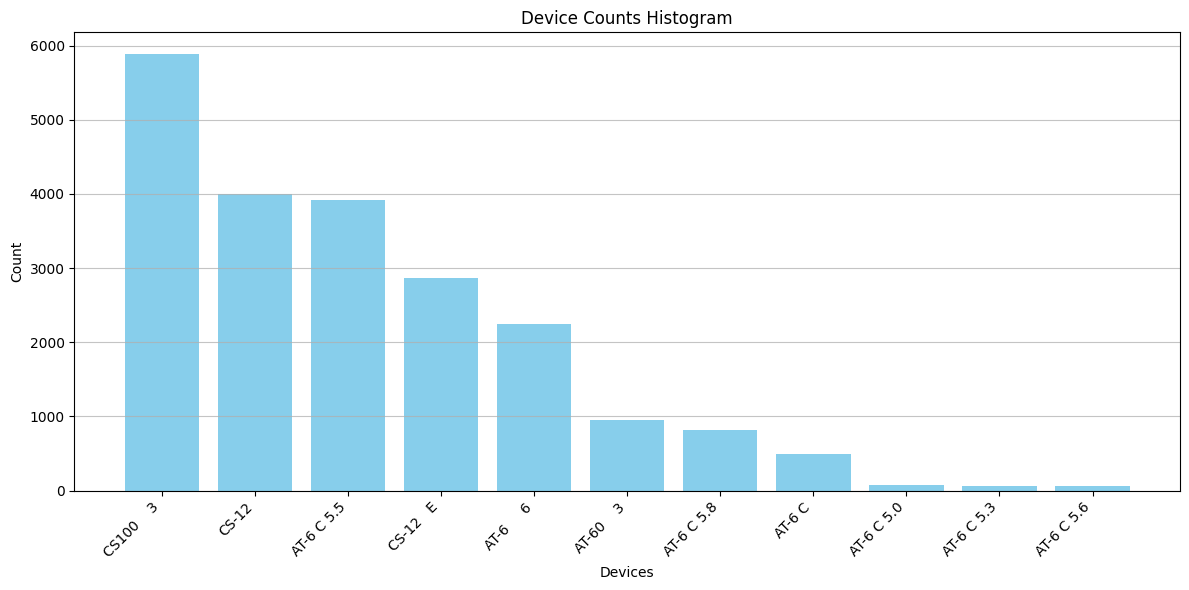

In [4]:
device_counts = df['device'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(device_counts.index, device_counts.values, color='skyblue')
plt.title('Device Counts Histogram')
plt.xlabel('Devices')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate device names for better readability
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


## Data Integrity

Now we check for measurement errors and artifacts

## Exporting of data

In [ ]:
X, y = prepare_training_data(path_to_data, df, 100)
output_path = "../data/processed"
os.makedirs(output_path, exist_ok=True)

np.save(join(output_path, 'X.npy'), X)
y.to_csv(join(output_path, "y.csv"))
